In [1]:
!pip install networkx


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# Graph Construction

In [1]:
import pandas as pd
import networkx as nx
import numpy as np

In [2]:
df = pd.read_excel("SFHH1.xlsx")

In [3]:
G = nx.Graph()

In [4]:
edges = df[["node1", "node2"]].drop_duplicates().values.tolist()

In [5]:
G.add_edges_from(edges)

## Question 1

In [7]:
N = G.number_of_nodes() 
print("Number of Nodes: ", N)

Number of Nodes:  403


In [8]:
E = G.number_of_edges()
print("Number of Edges: ", E)

Number of Edges:  9510


In [9]:
degrees = []
for node, degree in G.degree():
    degrees.append(degree)

In [10]:
avg_degree = np.mean(degrees).round(2)
std_degree = np.std(degrees).round(2)
print("Average Degree: ", avg_degree)
print("Standard Deviation of Degrees: ", std_degree)

Average Degree:  47.2
Standard Deviation of Degrees:  29.95


## Question 2

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
# sns.set_style(style = "dark")
sns.set_style("dark")
sns.set_palette("bone")

Text(0.5, 1.0, 'Degree Distribution')

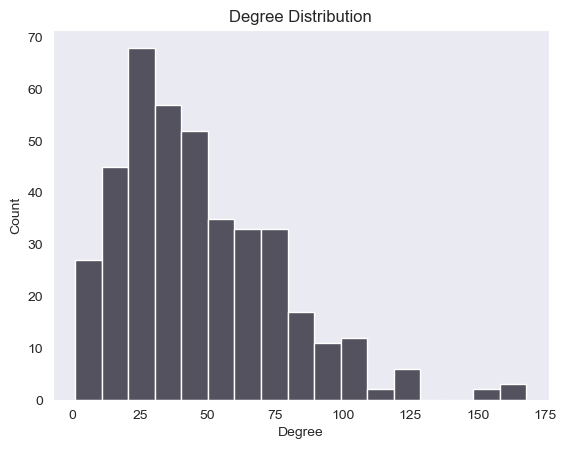

In [13]:
d_viz = sns.histplot(degrees)
d_viz.set_xlabel('Degree')
d_viz.set_ylabel('Count')
d_viz.set_title('Degree Distribution')

## Question 3

In [14]:
rho_D = nx.degree_assortativity_coefficient(G)
print("Degree assortativity: ", rho_D)

Degree assortativity:  -0.08001195267658665


## Question 4

In [15]:
C = nx.average_clustering(G)
print("Clustering coefficient: ", C)

Clustering coefficient:  0.27752342886036674


## Question 5

In [16]:
Eh = nx.average_shortest_path_length(G)
Hmax = nx.diameter(G)
print("Average Hopcount: ", Eh)
print("Diameter of Graph: ", Hmax)

Average Hopcount:  1.955211535375233
Diameter of Graph:  4


## Question 6

In [39]:
# creating a random graph
R = nx.gnm_random_graph(N, E)

In [41]:
C_rand = nx.average_clustering(R)
Eh_rand = nx.average_shortest_path_length(R)

print("Random Graph Clustering:", C_rand)
print("Random Graph Average Hopcount:", Eh_rand)

Random Graph Clustering: 0.11641847967354954
Random Graph Average Hopcount: 1.8857202819648655


Since C of our graph > random graph and path length is similar, we can conclude that the graph does follow small world property.

## Question 7


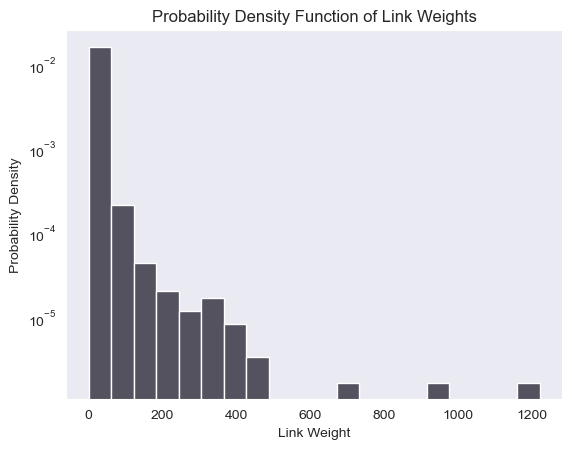

In [38]:
link_weights = df.groupby(['node1', 'node2']).size().values

# plt.figure(figsize=(10, 6))
sns.histplot(link_weights, bins=20, stat='density')
plt.xlabel('Link Weight')
plt.ylabel('Probability Density')
plt.title('Probability Density Function of Link Weights')
plt.yscale('log') 
plt.show()

## Question 8

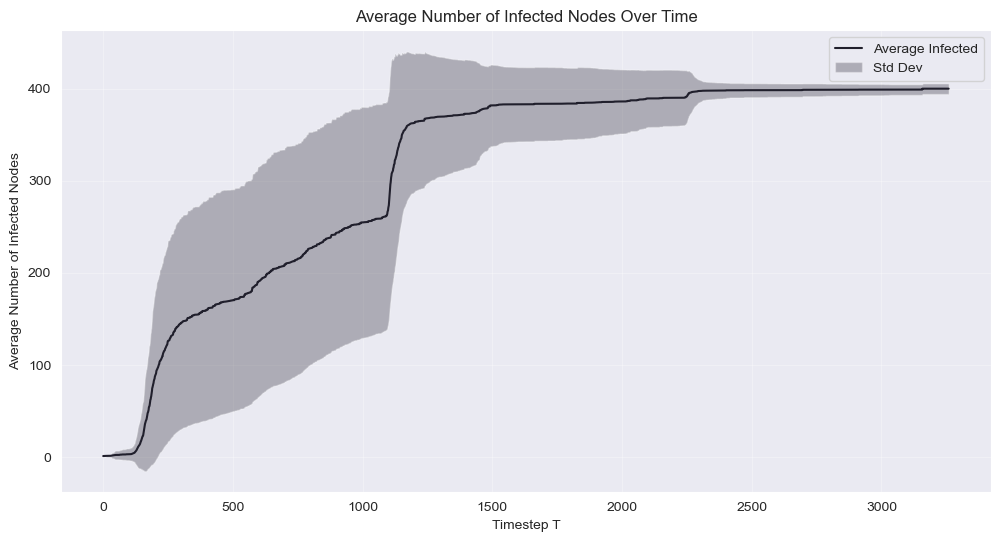

In [17]:
# Setup
df_sorted = df.sort_values('timestamp')
all_nodes = list(G.nodes())
T = df_sorted['timestamp'].max()
N = len(all_nodes)

# Store infection counts for each iteration
infTime_all = np.zeros((N, T+1))

for idx, seed in enumerate(all_nodes):
    infected = set([seed])
    infected_time = {seed: 0}
    infTime = np.zeros(T+1)
    infTime[0] = 1

    for t in range(1, T+1):
        # Get all contacts at time t
        contacts = df_sorted[df_sorted['timestamp'] == t][['node1', 'node2']].values
        new_infected = set()
        for n1, n2 in contacts:
            if n1 in infected and n2 not in infected:
                new_infected.add(n2)
            elif n2 in infected and n1 not in infected:
                new_infected.add(n1)
        infected.update(new_infected)
        infTime[t] = len(infected)
    infTime_all[idx] = infTime

# Calculate average and std deviation over all seeds
avg_inf = infTime_all.mean(axis=0)
std_inf = infTime_all.std(axis=0)

# Plot
plt.figure(figsize=(12,6))
plt.plot(range(T+1), avg_inf, label='Average Infected')
plt.fill_between(range(T+1), avg_inf-std_inf, avg_inf+std_inf, alpha=0.3, label='Std Dev')
plt.xlabel('Timestep T')
plt.ylabel('Average Number of Infected Nodes')
plt.title('Average Number of Infected Nodes Over Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Question 9

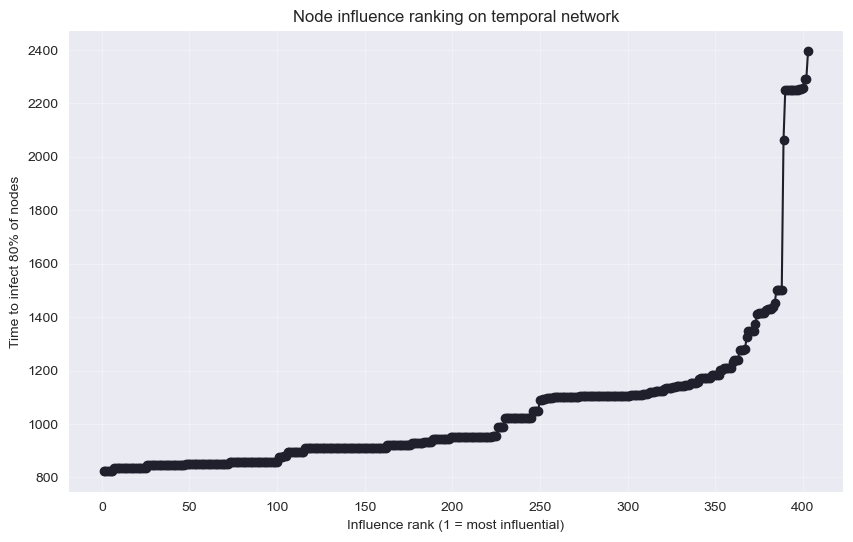

In [19]:

threshold = int(0.8 * N)   # 80% of all nodes
times_to_threshold = []

for idx, seed in enumerate(all_nodes):
    infected_counts = infTime_all[idx, :]
    reach_times = np.where(infected_counts >= threshold)[0]
    if len(reach_times) > 0:
        t_star = reach_times[0]   # first time reaching 80%
    else:
        t_star = np.inf           # never reached threshold
    times_to_threshold.append((seed, t_star))

# Sort by time to reach 80%
times_to_threshold.sort(key=lambda x: x[1])

# Ranking vector R (node indices in order of influence)
R = [seed for seed, _ in times_to_threshold]

# Sorted times for plotting
sorted_times = [t for _, t in times_to_threshold]

# Plot influence ranking
plt.figure(figsize=(10,6))
plt.plot(range(1, N+1), sorted_times, marker='o', linestyle='-')
plt.xlabel("Influence rank (1 = most influential)")
plt.ylabel("Time to infect 80% of nodes")
plt.title("Node influence ranking on temporal network")
plt.grid(True, alpha=0.3)
plt.show()


## Question 10

In [26]:

degrees = dict(G.degree())

strengths = {}

first_contact_times = {}
Z = []

for node in G.nodes():
    strength = 0
    for neighbor in G.neighbors(node):
        contacts = df[((df['node1'] == node) & (df['node2'] == neighbor)) | 
                     ((df['node1'] == neighbor) & (df['node2'] == node))].shape[0]
        strength += contacts
    strengths[node] = strength

degree_sorted = sorted(degrees.items(), key=lambda x: x[1], reverse=True)
D = [node for node, _ in degree_sorted]

strength_sorted = sorted(strengths.items(), key=lambda x: x[1], reverse=True)
S = [node for node, _ in strength_sorted]

In [27]:
def get_random_top_f(ranking_list, f, num_iterations=1000):

    n_nodes = len(ranking_list)
    top_f_size = int(f * n_nodes)
    
    if ranking_list == D:
        values = [degrees[node] for node in ranking_list]
    elif ranking_list == S:
        values = [strengths[node] for node in ranking_list]
    elif ranking_list == Z:
        values = [first_contact_times[node] for node in ranking_list]
    
    # Sort values: descending for degree/strength, ascending for first contact time
    if ranking_list == Z:
        unique_values = sorted(set(values))  # ascending for first contact time
    else:
        unique_values = sorted(set(values), reverse=True)  # descending for degree/strength
    value_counts = {}
    for val in unique_values:
        value_counts[val] = values.count(val)
    
    cumulative_count = 0
    tie_needed = False
    tie_value = None
    fixed_nodes = []
    
    for val in unique_values:
        if cumulative_count + value_counts[val] <= top_f_size:
            nodes_with_val = [node for node, node_val in zip(ranking_list, values) if node_val == val]
            fixed_nodes.extend(nodes_with_val)
            cumulative_count += value_counts[val]
        else:
            tie_needed = True
            tie_value = val
            break
    
    if not tie_needed:
        return [fixed_nodes] * num_iterations
    
    tie_nodes = [node for node, node_val in zip(ranking_list, values) if node_val == tie_value]
    remaining_slots = top_f_size - len(fixed_nodes)
    
    random_selections = []
    for _ in range(num_iterations):
        selected_tie_nodes = np.random.choice(tie_nodes, remaining_slots, replace=False)
        random_selections.append(fixed_nodes + list(selected_tie_nodes))
    
    return random_selections


f_values = np.arange(0.05, 0.55, 0.05)
rRD_values = []
rRS_values = []

for f in f_values:

    top_f_size = int(f * N)
    R_f = set(R[:top_f_size])
    
    D_f_iterations = get_random_top_f(D, f)
    rRD_rates = []
    for D_f_nodes in D_f_iterations:
        D_f = set(D_f_nodes)
        rate = len(R_f.intersection(D_f)) / len(R_f)
        rRD_rates.append(rate)
    rRD_values.append(np.mean(rRD_rates))
    
    S_f_iterations = get_random_top_f(S, f)
    rRS_rates = []
    for S_f_nodes in S_f_iterations:
        S_f = set(S_f_nodes)
        rate = len(R_f.intersection(S_f)) / len(R_f)
        rRS_rates.append(rate)
    rRS_values.append(np.mean(rRS_rates))

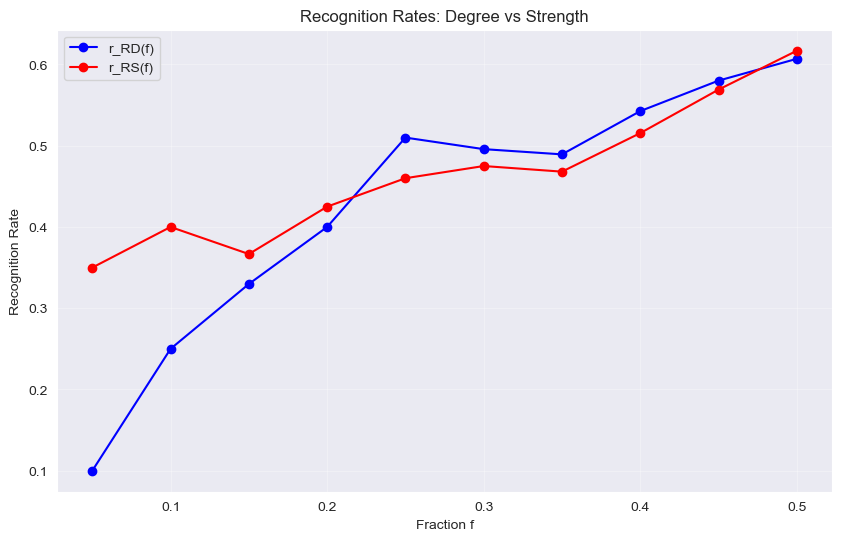

In [28]:
# Plot recognition rates
plt.figure(figsize=(10, 6))
plt.plot(f_values, rRD_values, 'bo-', label='r_RD(f)')
plt.plot(f_values, rRS_values, 'ro-', label='r_RS(f)')
plt.xlabel('Fraction f')
plt.ylabel('Recognition Rate')
plt.title('Recognition Rates: Degree vs Strength')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Question 11

In [39]:
first_contact_times = {}

for node in G.nodes():
    node_contacts = df[(df['node1'] == node) | (df['node2'] == node)]
    first_contact_times[node] = node_contacts['timestamp'].min()

first_contact_sorted = sorted(first_contact_times.items(), key=lambda x: x[1])
Z = [node for node, _ in first_contact_sorted]

rRZ_values = []

for f in f_values:
    top_f_size = int(f * N)
    R_f = set(R[:top_f_size])
    
    Z_f_iterations = get_random_top_f(Z, f)
    rRZ_rates = []
    for Z_f_nodes in Z_f_iterations:
        Z_f = set(Z_f_nodes)
        rate = len(R_f.intersection(Z_f)) / len(R_f)
        rRZ_rates.append(rate)
    rRZ_values.append(np.mean(rRZ_rates))

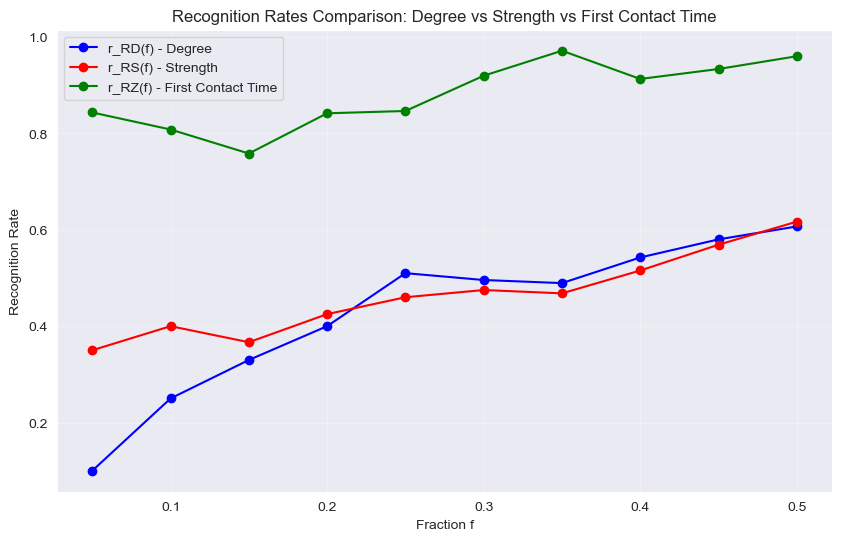

In [41]:
plt.figure(figsize=(10, 6))
plt.plot(f_values, rRD_values, 'bo-', label='r_RD(f) - Degree')
plt.plot(f_values, rRS_values, 'ro-', label='r_RS(f) - Strength')
plt.plot(f_values, rRZ_values, 'go-', label='r_RZ(f) - First Contact Time')
plt.xlabel('Fraction f')
plt.ylabel('Recognition Rate')
plt.title('Recognition Rates Comparison: Degree vs Strength vs First Contact Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()